## Librerias

In [1]:
from auxiliares import woe,iv,categorizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc,plot_ks_statistic

sns.set()
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Lectura de datos

In [2]:
ruta='/home/asm/amv/credit_scoring/datos/GiveMeSomeCredit'

In [3]:
df=pd.read_csv(ruta+'/cs-training.csv',index_col=0)
df.reset_index(drop=True,inplace=True)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
df.shape

(150000, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

## Definicón de la variable objetivo

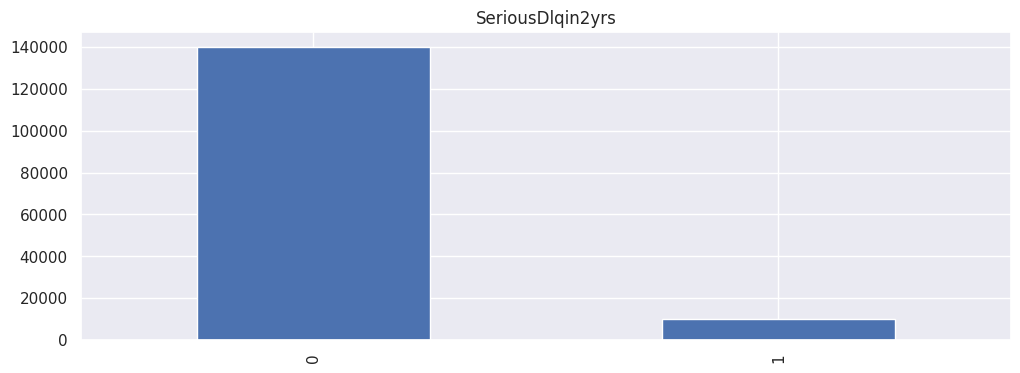

In [6]:
df['SeriousDlqin2yrs'].value_counts(dropna=False).plot(kind='bar',title='SeriousDlqin2yrs',figsize=(12,4))
plt.show()

In [7]:
target=['SeriousDlqin2yrs']

varc=['RevolvingUtilizationOfUnsecuredLines','age','DebtRatio',
      'MonthlyIncome','NumberOfOpenCreditLinesAndLoans']

vard=['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate',
      'NumberRealEstateLoansOrLines','NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']

## Análisis exploratorio de datos de variables continuas

### Valores falantes

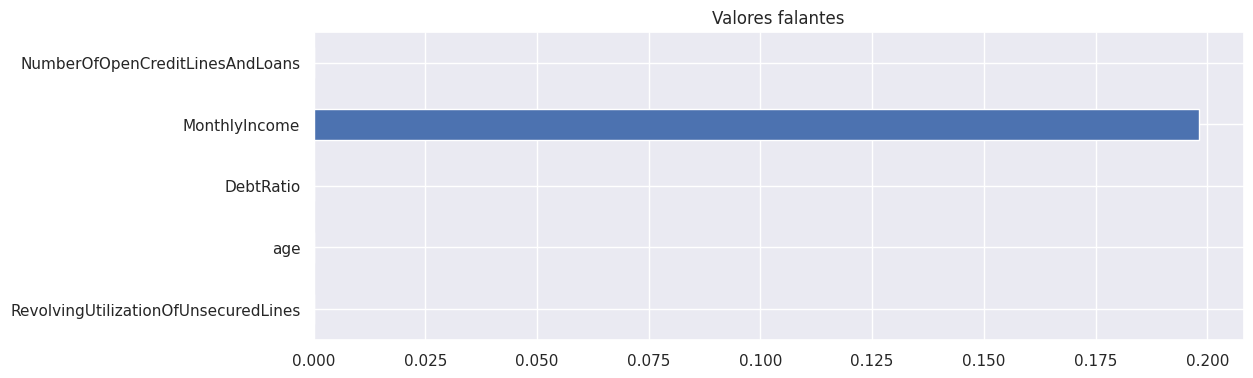

In [8]:
df[varc].isna().mean().plot(kind='barh',title='Valores falantes',figsize=(12,4))
plt.show()

In [9]:
im=SimpleImputer(strategy='median')
im.fit(df[varc])

SimpleImputer(strategy='median')

In [10]:
X_i=pd.DataFrame(im.transform(df[varc]),columns=varc)
X_i.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans
0,0.766127,45.0,0.802982,9120.0,13.0
1,0.957151,40.0,0.121876,2600.0,4.0
2,0.658180,38.0,0.085113,3042.0,2.0
3,0.233810,30.0,0.036050,3300.0,5.0
4,0.907239,49.0,0.024926,63588.0,7.0


In [11]:
ks=pd.Series({var:stat for var,stat in zip(varc,map(lambda x:ks_2samp(df[x].dropna(),X_i[x]).statistic,varc))})\
.reset_index().rename(columns={'index':'variable',0:'ks'})
ks

,variable,ks
0,RevolvingUtilizationOfUnsecuredLines,0.000000
1,age,0.000000
2,DebtRatio,0.000000
3,MonthlyIncome,0.098855
4,NumberOfOpenCreditLinesAndLoans,0.000000


### Discretización

In [12]:
df_disc=[]
discretizar={}
trans=[]
for n in range(4,9):
    kb=KBinsDiscretizer(n_bins=n,encode='ordinal',strategy='quantile')
    kb.fit(X_i)
    varc_aux=[f'disc_{x}_{n}' for x in varc]
    aux=pd.DataFrame(kb.transform(X_i),columns=varc_aux)
    mapa={k:v for k,v in zip(varc_aux,map(lambda x:{k:str(v).replace(')',']') for k,v in enumerate(zip(np.round(x,1),np.round(x[1:],1)))},kb.bin_edges_))}
    aux=aux.replace(mapa)
    discretizar.update(mapa)
    trans.append(kb)
    df_disc.append(aux)

In [13]:
X_disc=pd.concat(df_disc,axis=1)
X_disc.head()

,disc_RevolvingUtilizationOfUnsecuredLines_4,disc_age_4,disc_DebtRatio_4,disc_MonthlyIncome_4,disc_NumberOfOpenCreditLinesAndLoans_4,disc_RevolvingUtilizationOfUnsecuredLines_5,disc_age_5,disc_DebtRatio_5,disc_MonthlyIncome_5,disc_NumberOfOpenCreditLinesAndLoans_5,disc_RevolvingUtilizationOfUnsecuredLines_6,disc_age_6,disc_DebtRatio_6,disc_MonthlyIncome_6,disc_NumberOfOpenCreditLinesAndLoans_6,disc_RevolvingUtilizationOfUnsecuredLines_7,disc_age_7,disc_DebtRatio_7,disc_MonthlyIncome_7,disc_NumberOfOpenCreditLinesAndLoans_7,disc_RevolvingUtilizationOfUnsecuredLines_8,disc_age_8,disc_DebtRatio_8,disc_MonthlyIncome_8,disc_NumberOfOpenCreditLinesAndLoans_8
0,"(0.6, 50708.0]","(41.0, 52.0]","(0.4, 0.9]","(7400.0, 3008750.0]","(11.0, 58.0]","(0.7, 50708.0]","(39.0, 48.0]","(0.5, 4.0]","(8250.0, 3008750.0]","(12.0, 58.0]","(0.4, 0.8]","(45.0, 52.0]","(0.6, 76.0]","(9000.0, 3008750.0]","(13.0, 58.0]","(0.5, 0.9]","(43.0, 49.0]","(0.7, 400.0]","(6824.0, 9583.0]","(11.0, 14.0]","(0.6, 0.9]","(41.0, 47.0]","(0.5, 0.9]","(7400.0, 10000.0]","(11.0, 14.0]"
1,"(0.6, 50708.0]","(0.0, 41.0]","(0.0, 0.2]","(0.0, 3903.0]","(0.0, 5.0]","(0.7, 50708.0]","(39.0, 48.0]","(0.0, 0.1]","(0.0, 3400.0]","(4.0, 6.0]","(0.8, 50708.0]","(37.0, 45.0]","(0.1, 0.2]","(0.0, 3000.0]","(4.0, 6.0]","(0.9, 50708.0]","(35.0, 43.0]","(0.1, 0.2]","(0.0, 2800.0]","(3.0, 5.0]","(0.9, 50708.0]","(34.0, 41.0]","(0.1, 0.2]","(2593.9, 3903.0]","(3.0, 5.0]"
2,"(0.6, 50708.0]","(0.0, 41.0]","(0.0, 0.2]","(0.0, 3903.0]","(0.0, 5.0]","(0.3, 0.7]","(0.0, 39.0]","(0.0, 0.1]","(0.0, 3400.0]","(0.0, 4.0]","(0.4, 0.8]","(37.0, 45.0]","(0.0, 0.1]","(3000.0, 4700.0]","(0.0, 4.0]","(0.5, 0.9]","(35.0, 43.0]","(0.1, 0.2]","(2800.0, 4192.0]","(0.0, 3.0]","(0.6, 0.9]","(34.0, 41.0]","(0.1, 0.2]","(2593.9, 3903.0]","(0.0, 3.0]"
3,"(0.2, 0.6]","(0.0, 41.0]","(0.0, 0.2]","(0.0, 3903.0]","(5.0, 8.0]","(0.1, 0.3]","(0.0, 39.0]","(0.0, 0.1]","(0.0, 3400.0]","(4.0, 6.0]","(0.2, 0.4]","(0.0, 37.0]","(0.0, 0.1]","(3000.0, 4700.0]","(4.0, 6.0]","(0.2, 0.5]","(0.0, 35.0]","(0.0, 0.1]","(2800.0, 4192.0]","(5.0, 7.0]","(0.2, 0.3]","(0.0, 34.0]","(0.0, 0.1]","(2593.9, 3903.0]","(5.0, 6.0]"
4,"(0.6, 50708.0]","(41.0, 52.0]","(0.0, 0.2]","(7400.0, 3008750.0]","(5.0, 8.0]","(0.7, 50708.0]","(48.0, 56.0]","(0.0, 0.1]","(8250.0, 3008750.0]","(6.0, 9.0]","(0.8, 50708.0]","(45.0, 52.0]","(0.0, 0.1]","(9000.0, 3008750.0]","(6.0, 8.0]","(0.9, 50708.0]","(49.0, 55.0]","(0.0, 0.1]","(9583.0, 3008750.0]","(7.0, 8.0]","(0.6, 0.9]","(47.0, 52.0]","(0.0, 0.1]","(10000.0, 3008750.0]","(6.0, 8.0]"


## Análisis exploratorio de datos de variables discretas

### Valores falantes

<Axes: title={'center': 'Valores falantes'}>

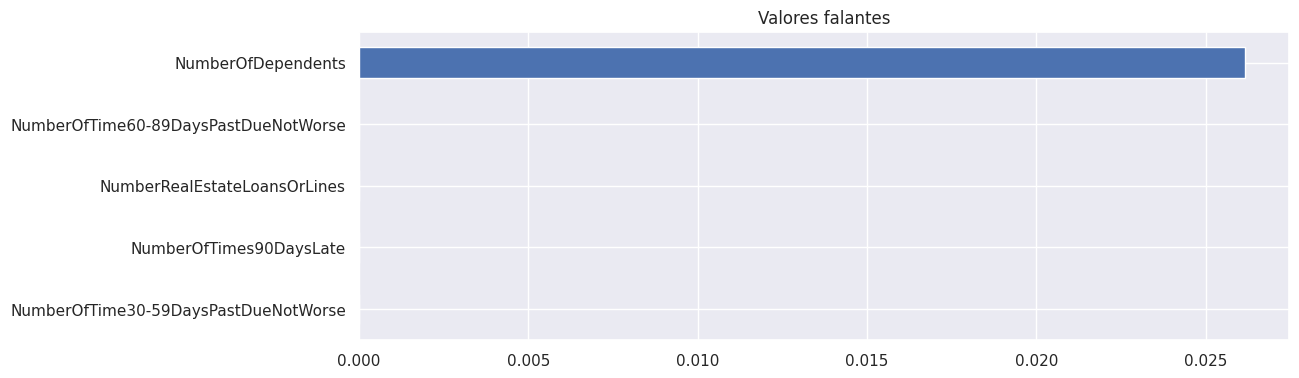

In [14]:
df[vard].isna().mean().plot(kind='barh',title='Valores falantes',figsize=(12,4))

In [15]:
df[vard]=df[vard].fillna('missing')
df[vard]=df[vard].astype(str)

### Categorización

In [16]:
for var in vard:
    print(var.center(50,'-'),'\n')
    print(df[var].value_counts(normalize=True).round(2),'\n\n')

-------NumberOfTime30-59DaysPastDueNotWorse------- 

0     0.84
1     0.11
2     0.03
3     0.01
4     0.00
5     0.00
98    0.00
6     0.00
7     0.00
8     0.00
9     0.00
96    0.00
10    0.00
12    0.00
13    0.00
11    0.00
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64 


-------------NumberOfTimes90DaysLate-------------- 

0     0.94
1     0.03
2     0.01
3     0.00
4     0.00
98    0.00
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.00
96    0.00
11    0.00
13    0.00
15    0.00
14    0.00
12    0.00
17    0.00
Name: NumberOfTimes90DaysLate, dtype: float64 


-----------NumberRealEstateLoansOrLines----------- 

0     0.37
1     0.35
2     0.21
3     0.04
4     0.01
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.00
11    0.00
12    0.00
13    0.00
15    0.00
14    0.00
17    0.00
16    0.00
25    0.00
18    0.00
23    0.00
19    0.00
20    0.00
26    0.00
54    0.00
21    0.00
29    0.00
32    0.00
Name: NumberRealEstateLoansOrLines, d

In [17]:
df['NumberOfTime30-59DaysPastDueNotWorse']=categorizar(df,'NumberOfTime30-59DaysPastDueNotWorse',.05,'2+')
df['NumberOfTimes90DaysLate']=categorizar(df,'NumberOfTimes90DaysLate',.05,'1+')
df['NumberRealEstateLoansOrLines']=categorizar(df,'NumberRealEstateLoansOrLines',.05,'3+')
df['NumberOfTime60-89DaysPastDueNotWorse']=categorizar(df,'NumberOfTime60-89DaysPastDueNotWorse',.05,'1+')
df['NumberOfDependents']=categorizar(df,'NumberOfDependents',.05,'4+')

In [18]:
for var in vard:
    print(var.center(50,'-'),'\n')
    print(df[var].value_counts(normalize=True).round(2),'\n\n')

-------NumberOfTime30-59DaysPastDueNotWorse------- 

0     0.84
1     0.11
2+    0.05
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64 


-------------NumberOfTimes90DaysLate-------------- 

0     0.94
1+    0.06
Name: NumberOfTimes90DaysLate, dtype: float64 


-----------NumberRealEstateLoansOrLines----------- 

0     0.37
1     0.35
2     0.21
3+    0.07
Name: NumberRealEstateLoansOrLines, dtype: float64 


-------NumberOfTime60-89DaysPastDueNotWorse------- 

0     0.95
1+    0.05
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64 


----------------NumberOfDependents---------------- 

0.0    0.58
1.0    0.18
2.0    0.13
3.0    0.06
4+     0.05
Name: NumberOfDependents, dtype: float64 




## Partición de datos

In [19]:
muestra=pd.concat([df[vard],X_disc,df[target]],axis=1)
muestra.head()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,disc_RevolvingUtilizationOfUnsecuredLines_4,disc_age_4,disc_DebtRatio_4,disc_MonthlyIncome_4,disc_NumberOfOpenCreditLinesAndLoans_4,disc_RevolvingUtilizationOfUnsecuredLines_5,disc_age_5,disc_DebtRatio_5,disc_MonthlyIncome_5,disc_NumberOfOpenCreditLinesAndLoans_5,disc_RevolvingUtilizationOfUnsecuredLines_6,disc_age_6,disc_DebtRatio_6,disc_MonthlyIncome_6,disc_NumberOfOpenCreditLinesAndLoans_6,disc_RevolvingUtilizationOfUnsecuredLines_7,disc_age_7,disc_DebtRatio_7,disc_MonthlyIncome_7,disc_NumberOfOpenCreditLinesAndLoans_7,disc_RevolvingUtilizationOfUnsecuredLines_8,disc_age_8,disc_DebtRatio_8,disc_MonthlyIncome_8,disc_NumberOfOpenCreditLinesAndLoans_8,SeriousDlqin2yrs
0,2+,0,3+,0,2.0,"(0.6, 50708.0]","(41.0, 52.0]","(0.4, 0.9]","(7400.0, 3008750.0]","(11.0, 58.0]","(0.7, 50708.0]","(39.0, 48.0]","(0.5, 4.0]","(8250.0, 3008750.0]","(12.0, 58.0]","(0.4, 0.8]","(45.0, 52.0]","(0.6, 76.0]","(9000.0, 3008750.0]","(13.0, 58.0]","(0.5, 0.9]","(43.0, 49.0]","(0.7, 400.0]","(6824.0, 9583.0]","(11.0, 14.0]","(0.6, 0.9]","(41.0, 47.0]","(0.5, 0.9]","(7400.0, 10000.0]","(11.0, 14.0]",1
1,0,0,0,0,1.0,"(0.6, 50708.0]","(0.0, 41.0]","(0.0, 0.2]","(0.0, 3903.0]","(0.0, 5.0]","(0.7, 50708.0]","(39.0, 48.0]","(0.0, 0.1]","(0.0, 3400.0]","(4.0, 6.0]","(0.8, 50708.0]","(37.0, 45.0]","(0.1, 0.2]","(0.0, 3000.0]","(4.0, 6.0]","(0.9, 50708.0]","(35.0, 43.0]","(0.1, 0.2]","(0.0, 2800.0]","(3.0, 5.0]","(0.9, 50708.0]","(34.0, 41.0]","(0.1, 0.2]","(2593.9, 3903.0]","(3.0, 5.0]",0
2,1,1+,0,0,0.0,"(0.6, 50708.0]","(0.0, 41.0]","(0.0, 0.2]","(0.0, 3903.0]","(0.0, 5.0]","(0.3, 0.7]","(0.0, 39.0]","(0.0, 0.1]","(0.0, 3400.0]","(0.0, 4.0]","(0.4, 0.8]","(37.0, 45.0]","(0.0, 0.1]","(3000.0, 4700.0]","(0.0, 4.0]","(0.5, 0.9]","(35.0, 43.0]","(0.1, 0.2]","(2800.0, 4192.0]","(0.0, 3.0]","(0.6, 0.9]","(34.0, 41.0]","(0.1, 0.2]","(2593.9, 3903.0]","(0.0, 3.0]",0
3,0,0,0,0,0.0,"(0.2, 0.6]","(0.0, 41.0]","(0.0, 0.2]","(0.0, 3903.0]","(5.0, 8.0]","(0.1, 0.3]","(0.0, 39.0]","(0.0, 0.1]","(0.0, 3400.0]","(4.0, 6.0]","(0.2, 0.4]","(0.0, 37.0]","(0.0, 0.1]","(3000.0, 4700.0]","(4.0, 6.0]","(0.2, 0.5]","(0.0, 35.0]","(0.0, 0.1]","(2800.0, 4192.0]","(5.0, 7.0]","(0.2, 0.3]","(0.0, 34.0]","(0.0, 0.1]","(2593.9, 3903.0]","(5.0, 6.0]",0
4,1,0,1,0,0.0,"(0.6, 50708.0]","(41.0, 52.0]","(0.0, 0.2]","(7400.0, 3008750.0]","(5.0, 8.0]","(0.7, 50708.0]","(48.0, 56.0]","(0.0, 0.1]","(8250.0, 3008750.0]","(6.0, 9.0]","(0.8, 50708.0]","(45.0, 52.0]","(0.0, 0.1]","(9000.0, 3008750.0]","(6.0, 8.0]","(0.9, 50708.0]","(49.0, 55.0]","(0.0, 0.1]","(9583.0, 3008750.0]","(7.0, 8.0]","(0.6, 0.9]","(47.0, 52.0]","(0.0, 0.1]","(10000.0, 3008750.0]","(6.0, 8.0]",0


In [20]:
train,test=train_test_split(muestra,test_size=.3,random_state=11238,stratify=muestra[target])
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
train.shape,test.shape

((105000, 31), (45000, 31))

## Tranformación WoE en los datos de entrenamiento

In [21]:
var=train.columns[:-1].tolist()

In [22]:
mapa_woe={x:woe(train,x,target[0])['woe'].to_dict() for x in var}
mapa_inv={x:{v:k for k,v in woe(train,x,target[0])['woe'].to_dict().items()} for x in var}

In [23]:
train_woe=train[var].replace(mapa_woe)
train_woe[target[0]]=train[target[0]]
train_woe.head()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,disc_RevolvingUtilizationOfUnsecuredLines_4,disc_age_4,disc_DebtRatio_4,disc_MonthlyIncome_4,disc_NumberOfOpenCreditLinesAndLoans_4,disc_RevolvingUtilizationOfUnsecuredLines_5,disc_age_5,disc_DebtRatio_5,disc_MonthlyIncome_5,disc_NumberOfOpenCreditLinesAndLoans_5,disc_RevolvingUtilizationOfUnsecuredLines_6,disc_age_6,disc_DebtRatio_6,disc_MonthlyIncome_6,disc_NumberOfOpenCreditLinesAndLoans_6,disc_RevolvingUtilizationOfUnsecuredLines_7,disc_age_7,disc_DebtRatio_7,disc_MonthlyIncome_7,disc_NumberOfOpenCreditLinesAndLoans_7,disc_RevolvingUtilizationOfUnsecuredLines_8,disc_age_8,disc_DebtRatio_8,disc_MonthlyIncome_8,disc_NumberOfOpenCreditLinesAndLoans_8,SeriousDlqin2yrs
0,-0.897069,0.392414,0.202176,0.285023,-0.326236,-1.116712,-0.193297,-0.224208,0.125054,0.144165,-1.246198,-0.089360,-0.421789,0.140581,0.045103,-1.317878,-0.150685,-0.086392,0.179219,0.045103,-1.382597,-0.108202,-0.218701,0.257195,0.127946,-0.745335,-0.134820,-0.038093,0.103927,0.035903,0
1,0.541666,0.392414,-0.301506,0.285023,-0.326236,1.320007,0.135610,-0.036569,0.125054,0.193514,1.253521,-0.089360,0.183850,0.140581,0.126489,1.193214,0.046126,0.136223,0.133229,0.227388,1.360535,-0.108202,0.179455,0.119838,0.193514,1.320007,-0.024538,0.271323,0.136909,0.109278,0
2,0.541666,0.392414,0.202176,-2.074759,0.131080,0.325712,0.135610,0.193675,0.368590,0.046962,0.865535,-0.089360,0.065763,0.398096,0.019344,0.575802,0.046126,0.218166,0.422569,0.015181,0.308483,-0.108202,0.043419,0.257195,-0.026568,0.680180,-0.024538,0.186177,0.272273,-0.026568,0
3,0.541666,0.392414,0.266629,0.285023,0.131080,1.320007,0.976201,-0.036569,0.125054,0.193514,1.253521,1.030785,0.183850,0.140581,0.245890,1.599487,1.100411,0.136223,0.133229,0.227388,1.360535,1.136920,0.179455,0.119838,0.193514,1.320007,0.843622,0.271323,0.136909,0.350218,0
4,-0.897069,0.392414,0.266629,0.285023,0.131080,1.320007,0.135610,0.112475,0.368590,0.046962,1.253521,0.364826,0.177866,0.140581,0.019344,1.193214,0.046126,0.100230,0.179219,0.015181,1.360535,0.222889,0.085305,0.257195,-0.026568,1.320007,0.297433,0.062292,0.272273,-0.026568,0


## Selección de variables

In [24]:
df_iv=pd.Series({x:iv(train,x,target[0]) for x in var}).reset_index().rename(columns={'index':'variable_woe',0:'iv'}).sort_values('iv',ascending=False).reset_index(drop=True)
df_iv['variable']=np.where(df_iv['variable_woe'].str.split('_').map(lambda x:'_'.join(x[:-1]))=='',df_iv['variable_woe'],df_iv['variable_woe'].str.split('_').map(lambda x:'_'.join(x[:-1])))
df_iv=df_iv.groupby('variable').first().sort_values('iv',ascending=False).reset_index(drop=True)
df_iv

,variable_woe,iv
0,disc_RevolvingUtilizationOfUnsecuredLines_8,1.098264
1,NumberOfTimes90DaysLate,0.842079
2,NumberOfTime30-59DaysPastDueNotWorse,0.740722
3,NumberOfTime60-89DaysPastDueNotWorse,0.565104
4,disc_age_8,0.260195
5,disc_NumberOfOpenCreditLinesAndLoans_8,0.082769
6,disc_MonthlyIncome_8,0.072912
7,NumberRealEstateLoansOrLines,0.060186
8,disc_DebtRatio_5,0.058060
9,NumberOfDependents,0.023859


In [25]:
best=df_iv['variable_woe'][df_iv['iv']>.1].tolist()
best

['disc_RevolvingUtilizationOfUnsecuredLines_8',
 'NumberOfTimes90DaysLate',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'disc_age_8']

## Regresión logística en los datos de entrenamiento

In [26]:
param_grid={'penalty':['l1', 'l2', None],
            'C':[.001,0.01,0.1,1,10],
            'class_weight':[None,'balanced']
            }

In [27]:
logreg=LogisticRegression()
gscv=GridSearchCV(logreg,param_grid,scoring='roc_auc',cv=5)
gscv.fit(train_woe[best],train_woe[target[0]])

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2', None]},
             scoring='roc_auc')

In [28]:
# mejores parametros
gscv.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [29]:
modelo=gscv.best_estimator_
modelo.fit(train_woe[best],train_woe[target[0]])

LogisticRegression(C=0.1, class_weight='balanced')

In [30]:
roc_auc_score(train_woe[target[0]],modelo.predict_proba(train_woe[best])[:,1])

0.8535118471315407

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

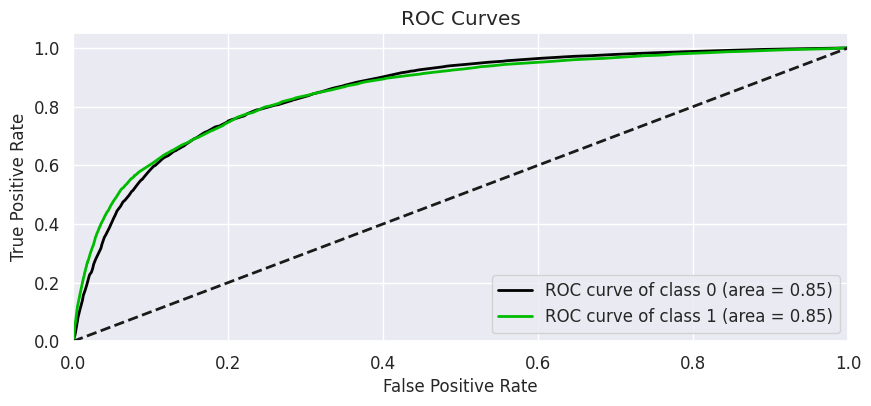

In [31]:
plot_roc(train_woe[target[0]],modelo.predict_proba(train_woe[best]),plot_micro=False,plot_macro=False,figsize=(10,4))

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

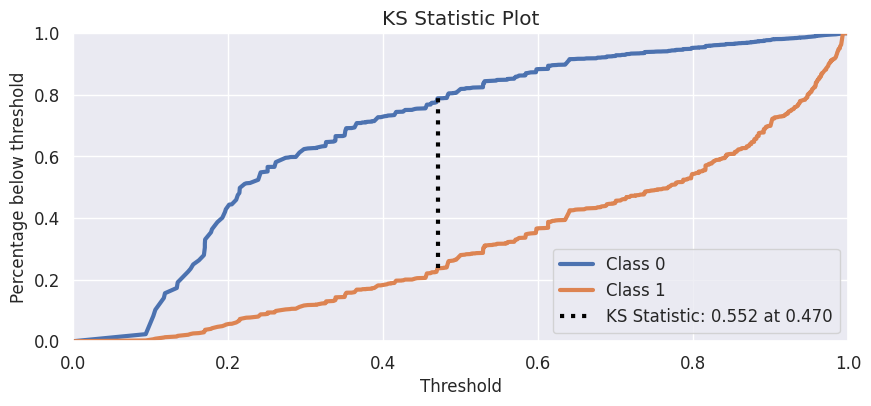

In [32]:
plot_ks_statistic(train_woe[target[0]],modelo.predict_proba(train_woe[best]),figsize=(10,4))

## Transformación WoE en los datos de prueba

In [33]:
test_woe=test[var].replace(mapa_woe)
test_woe[target[0]]=test[target[0]]
test_woe.head()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,disc_RevolvingUtilizationOfUnsecuredLines_4,disc_age_4,disc_DebtRatio_4,disc_MonthlyIncome_4,disc_NumberOfOpenCreditLinesAndLoans_4,disc_RevolvingUtilizationOfUnsecuredLines_5,disc_age_5,disc_DebtRatio_5,disc_MonthlyIncome_5,disc_NumberOfOpenCreditLinesAndLoans_5,disc_RevolvingUtilizationOfUnsecuredLines_6,disc_age_6,disc_DebtRatio_6,disc_MonthlyIncome_6,disc_NumberOfOpenCreditLinesAndLoans_6,disc_RevolvingUtilizationOfUnsecuredLines_7,disc_age_7,disc_DebtRatio_7,disc_MonthlyIncome_7,disc_NumberOfOpenCreditLinesAndLoans_7,disc_RevolvingUtilizationOfUnsecuredLines_8,disc_age_8,disc_DebtRatio_8,disc_MonthlyIncome_8,disc_NumberOfOpenCreditLinesAndLoans_8,SeriousDlqin2yrs
0,0.541666,0.392414,-0.237026,0.285023,0.131080,0.325712,-0.492568,0.193675,-0.133680,0.193514,-0.041642,-0.529398,0.177866,-0.169177,0.126489,0.575802,-0.568158,0.100230,-0.270766,0.109718,0.308483,-0.587273,0.257030,-0.289510,0.193514,0.680180,-0.606607,0.201199,-0.124386,0.109278,0
1,0.541666,0.392414,0.266629,0.285023,0.131080,1.271492,0.135610,-0.036569,0.125054,0.046962,1.491263,0.364826,0.183850,0.140581,0.019344,1.150685,0.046126,0.136223,0.133229,0.109718,1.350107,0.222889,0.179455,0.119838,0.130216,1.482112,-0.024538,0.271323,0.136909,0.130216,0
2,0.541666,0.392414,-0.237026,0.285023,-0.326236,-1.116712,-0.492568,0.193675,-0.133680,0.144165,-1.246198,-0.529398,0.177866,-0.169177,0.045103,-1.317878,-0.568158,0.100230,-0.071822,0.045103,-1.382597,-0.357244,0.257030,-0.145009,0.127946,-1.418016,-0.373347,0.201199,-0.124386,0.035903,0
3,0.541666,0.392414,0.266629,0.285023,-0.095769,1.320007,0.976201,-0.224208,-0.133680,0.046962,1.491263,1.030785,0.065763,-0.169177,0.019344,1.599487,1.100411,-0.086392,-0.270766,0.109718,1.360535,0.583822,0.043419,-0.145009,0.130216,1.320007,0.843622,-0.038093,-0.124386,0.130216,0
4,0.541666,0.392414,0.266629,0.285023,-0.180648,0.325712,-0.492568,0.193675,-0.339930,0.144165,0.865535,-0.529398,0.065763,-0.357698,0.045103,0.575802,-0.293211,0.218166,-0.337135,0.045103,0.308483,-0.357244,0.043419,-0.335206,0.127946,0.680180,-0.373347,0.186177,-0.373012,0.035903,0


## Evaluación del modelo

In [34]:
roc_auc_score(test_woe[target[0]],modelo.predict_proba(test_woe[best])[:,1])

0.8494731685531287

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

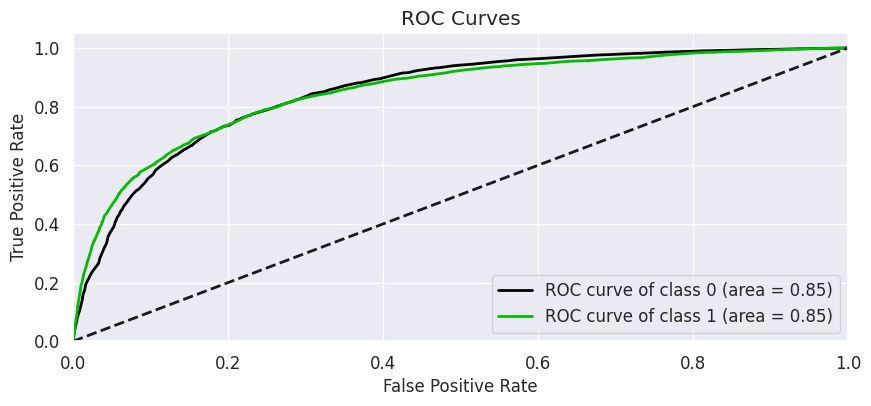

In [35]:
plot_roc(test_woe[target[0]],modelo.predict_proba(test_woe[best]),plot_micro=False,plot_macro=False,figsize=(10,4))

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

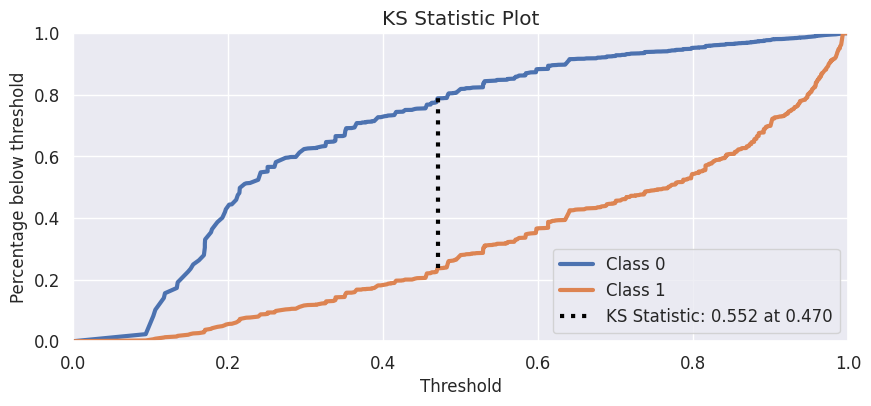

In [36]:
plot_ks_statistic(train_woe[target[0]],modelo.predict_proba(train_woe[best]),figsize=(10,4))

## Parámetros del modelo

In [37]:
modelo.intercept_

array([0.03494339])

In [38]:
modelo.coef_

array([[-0.68328392, -0.6109163 , -0.6346375 , -0.51816944, -0.50073506]])